# Regresión regularizada

Ejemplo con algoritmo Lasso y dataset Hitters.

El objetivo es construir un modelo para predecir el precio de venta de una casa en función de las características de una casa en particular.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 110

# scikit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../data/hitters.csv")
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

In [4]:
print(df.isnull().sum())

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


In [5]:
# drop missing cases
df = df.dropna()

## Create label and features

In [6]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6 KB


In [7]:
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [8]:
y = df['Salary']
y

1       475.0
2       480.0
3       500.0
4        91.5
5       750.0
        ...  
317     700.0
318     875.0
319     385.0
320     960.0
321    1000.0
Name: Salary, Length: 263, dtype: float64

In [9]:
# We drop the column with the outcome variable (Salary), and categorical columns for which we already created dummy variables:
X_numerical = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

In [10]:
# Make a list of all numerical features (we need them later):
list_numerical = X_numerical.columns
list_numerical

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

In [11]:
# Create all features
X = pd.concat([X_numerical, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8  
dtypes: float

## Split data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,496.0,119.0,8.0,57.0,33.0,21.0,7.0,3358.0,882.0,36.0,365.0,280.0,165.0,155.0,371.0,29.0,1,1,1
92,317.0,78.0,7.0,35.0,35.0,32.0,1.0,317.0,78.0,7.0,35.0,35.0,32.0,45.0,122.0,26.0,0,0,0
137,343.0,103.0,6.0,48.0,36.0,40.0,15.0,4338.0,1193.0,70.0,581.0,421.0,325.0,211.0,56.0,13.0,0,0,0
90,314.0,83.0,13.0,39.0,46.0,16.0,5.0,1457.0,405.0,28.0,156.0,159.0,76.0,533.0,40.0,4.0,0,1,0
100,495.0,151.0,17.0,61.0,84.0,78.0,10.0,5624.0,1679.0,275.0,884.0,1015.0,709.0,1045.0,88.0,13.0,0,0,0


In [13]:
y_train

260     875.0
92       70.0
137     430.0
90      431.5
100    2460.0
        ...  
274     200.0
196     587.5
159     200.0
17      175.0
162      75.0
Name: Salary, Length: 184, dtype: float64

## Data standardization

Some of our models perform best when all numerical features are centered around 0 and have variance in the same order (like Lasso, Ridge or GAMs).

To avoid data leakage, the standardization of numerical features should always be performed after data splitting and only from training data.

Furthermore, we obtain all necessary statistics for our features (mean and standard deviation) from training data and also use them on test data. Note that we don’t standardize our dummy variables (which only have values of 0 or 1).


StandardScaler estandariza una característica restando la media y luego escalando a la varianza de la unidad. La varianza unitaria significa dividir todos los valores por la desviación estándar. StandardScaler no cumple con la definición estricta de escala que presenté anteriormente.

StandardScaler da como resultado una distribución con una desviación estándar igual a 1. La varianza también es igual a 1, porque varianza = desviación estándar al cuadrado. Y 1 al cuadrado = 1.

La estandarización: Considere las columnas como variables. Si una columna está estandarizada, el valor medio de la columna se resta de cada valor y luego los valores se dividen por la desviación estándar de la columna. Las columnas resultantes tienen una desviación estándar de 1 y una media muy cercana a cero. Así, terminamos teniendo variables (columnas) que tienen una distribución casi normal. StandardScaler puede lograr la estandarización.

In [14]:
from sklearn.preprocessing import StandardScaler

# Solo se hace fit de X_train porque el modelo no debe conocer X_test
scaler = StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

In [15]:
X_train

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
260,0.644577,0.257439,-0.456963,0.101010,-0.763917,-0.975959,-0.070553,0.298535,0.239063,-0.407836,0.011298,-0.163736,-0.361084,-0.482387,1.746229,3.022233,1,1,1
92,-0.592807,-0.671359,-0.572936,-0.778318,-0.685806,-0.458312,-1.306911,-1.001403,-0.969702,-0.746705,-0.957639,-0.898919,-0.844319,-0.851547,0.022276,2.574735,0,0,0
137,-0.413075,-0.105019,-0.688910,-0.258715,-0.646751,-0.081841,1.577925,0.717456,0.706633,-0.010542,0.645511,0.259369,0.220252,-0.294452,-0.434676,0.635577,0,0,0
90,-0.613545,-0.558091,0.122907,-0.618440,-0.256196,-1.211253,-0.482672,-0.514087,-0.478077,-0.501317,-0.602362,-0.526826,-0.684451,0.786178,-0.545452,-0.706917,0,1,0
100,0.637665,0.982354,0.586803,0.260888,1.227914,1.706394,0.547626,1.267183,1.437305,2.384908,1.535171,2.041811,1.615457,2.504446,-0.213124,0.635577,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.824309,0.733164,0.470829,0.740521,0.954525,0.859335,-0.688732,-0.824858,-0.808834,-0.571428,-0.787341,-0.685866,-0.648118,3.427344,0.326910,1.232241,1,0,1
196,0.423369,0.461321,1.862516,0.500704,1.618469,0.482865,1.165805,1.354814,1.246368,1.625375,1.112362,1.516681,0.681687,-1.002566,-0.822392,-1.303581,0,1,0
159,1.474109,1.254197,1.746542,1.140215,2.126191,-0.458312,-0.894792,-0.522636,-0.520174,-0.068968,-0.528958,-0.322776,-0.662651,-0.633407,1.310048,0.933909,0,1,0
17,-1.470728,-1.396275,-1.152806,-1.217982,-1.740306,-1.258312,-0.482672,-0.932153,-0.933620,-0.770075,-0.869554,-0.934928,-0.818885,-0.660255,0.403069,1.083075,0,1,0


## Regresión lineal múltiple

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [17]:
print('R squared training set', round(model.score(X_train, y_train), 2))
print('R squared test set', round(model.score(X_test, y_test), 2))

R squared training set 0.61
R squared test set 0.26


In [18]:
y_pred = model.predict(X_test)
print('R squared test set', round(r2_score(y_test, y_pred), 2))

R squared test set 0.26


## Regresión Lasso

In [19]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=10)
model.fit(X_train, y_train)

Lasso(alpha=10)

In [20]:
print('R squared training set', round(model.score(X_train, y_train), 2))
print('R squared test set', round(model.score(X_test, y_test), 2))

R squared training set 0.53
R squared test set 0.37


In [21]:
# Training data
pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = model.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 95318.25
MSE test set 127162.51


## alpha parameter tuning

In [22]:
alphas = np.linspace(0.01,500,100)
alphas

array([1.00000000e-02, 5.06040404e+00, 1.01108081e+01, 1.51612121e+01,
       2.02116162e+01, 2.52620202e+01, 3.03124242e+01, 3.53628283e+01,
       4.04132323e+01, 4.54636364e+01, 5.05140404e+01, 5.55644444e+01,
       6.06148485e+01, 6.56652525e+01, 7.07156566e+01, 7.57660606e+01,
       8.08164646e+01, 8.58668687e+01, 9.09172727e+01, 9.59676768e+01,
       1.01018081e+02, 1.06068485e+02, 1.11118889e+02, 1.16169293e+02,
       1.21219697e+02, 1.26270101e+02, 1.31320505e+02, 1.36370909e+02,
       1.41421313e+02, 1.46471717e+02, 1.51522121e+02, 1.56572525e+02,
       1.61622929e+02, 1.66673333e+02, 1.71723737e+02, 1.76774141e+02,
       1.81824545e+02, 1.86874949e+02, 1.91925354e+02, 1.96975758e+02,
       2.02026162e+02, 2.07076566e+02, 2.12126970e+02, 2.17177374e+02,
       2.22227778e+02, 2.27278182e+02, 2.32328586e+02, 2.37378990e+02,
       2.42429394e+02, 2.47479798e+02, 2.52530202e+02, 2.57580606e+02,
       2.62631010e+02, 2.67681414e+02, 2.72731818e+02, 2.77782222e+02,
      

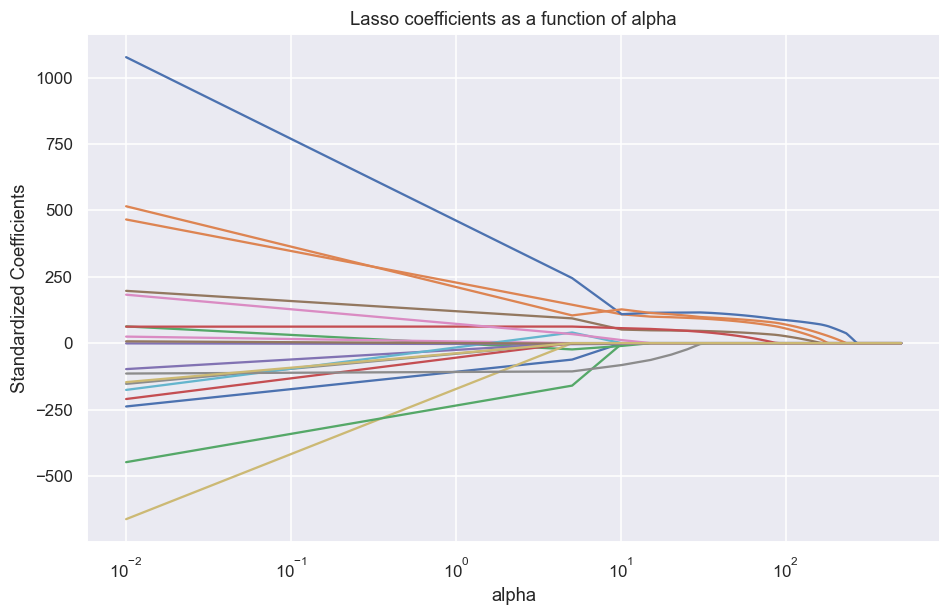

In [23]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

%matplotlib inline
sns.set()
plt.figure(figsize=(10,6))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [24]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=10, random_state=42, max_iter=20000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=10, max_iter=20000, random_state=42)

In [25]:
model.alpha_

2.6951735349877697

In [26]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=2.6951735349877697)

In [27]:
print('R squared training set', round(lasso_best.score(X_train, y_train), 2))
print('R squared test set', round(lasso_best.score(X_test, y_test), 2))

R squared training set 0.59
R squared test set 0.36


In [28]:
"""
La función zip() devuelve un objeto zip, que es un iterador de tuplas donde el primer elemento de cada iterador pasado se empareja, y luego el segundo elemento de cada iterador pasado se empareja, etc.

Si los iteradores pasados tienen diferentes longitudes, el iterador con menos elementos decide la longitud del nuevo iterador.
"""
print(list(zip(lasso_best.coef_, X)))

[(-162.57135869639683, 'AtBat'), (251.42672017043827, 'Hits'), (-17.026909772953783, 'HmRun'), (-38.383468227304455, 'Runs'), (-8.532073761828228, 'RBI'), (132.59197247259593, 'Walks'), (-7.535527210469767, 'Years'), (-0.0, 'CAtBat'), (0.0, 'CHits'), (75.54389063998359, 'CHmRun'), (340.87416157478697, 'CRuns'), (63.20337652759816, 'CRBI'), (-248.96313543586044, 'CWalks'), (65.46154681629646, 'PutOuts'), (-0.33594647151232676, 'Assists'), (-1.251883376115368, 'Errors'), (89.2315064766361, 'League_N'), (-115.19675899884201, 'Division_W'), (-57.56343446897899, 'NewLeague_N')]


In [29]:
mean_squared_error(y_test, lasso_best.predict(X_test))

128742.85024102202

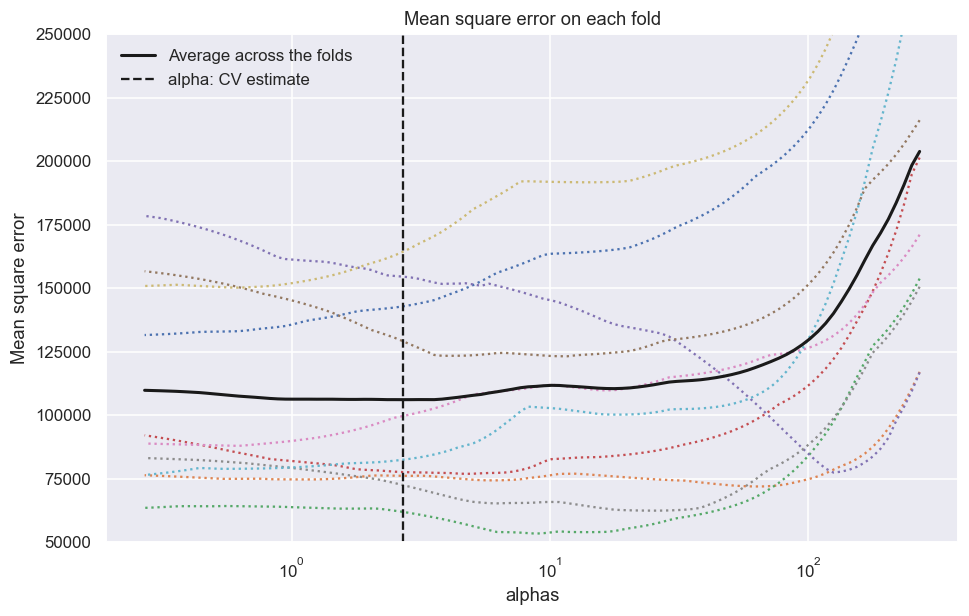

In [30]:
plt.figure(figsize=(10,6))
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);